In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from neurodsp.sim import *
from neurodsp.spectral import compute_spectrum

from fooof.plts import plot_spectrum, plot_spectra

In [21]:
# General simulation settings
n_seconds = 3
fs = 1000

In [22]:
# Specific settings
exp = -2

In [23]:
sig = sim_powerlaw(n_seconds, fs, exp)

In [24]:
spec_frac, spec_mixed, freq = irasa(sig, fs)

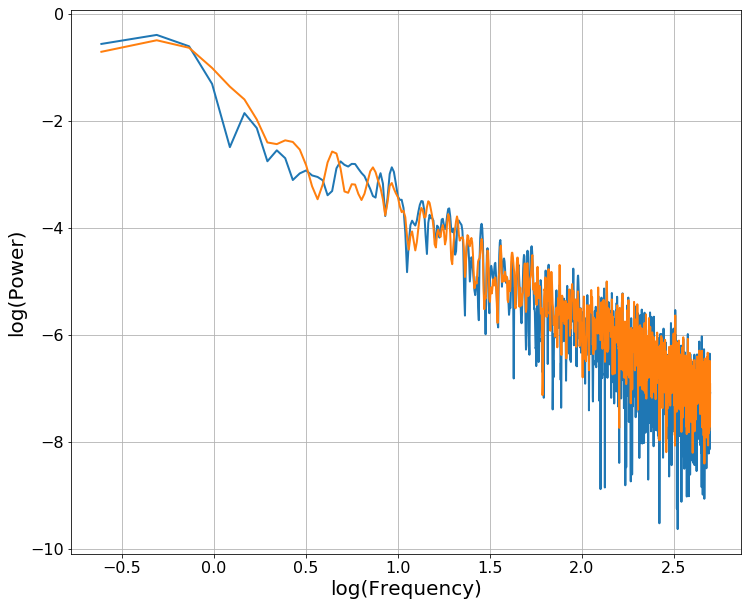

In [25]:
plot_spectra(freq, [spec_frac, spec_mixed], True, True)

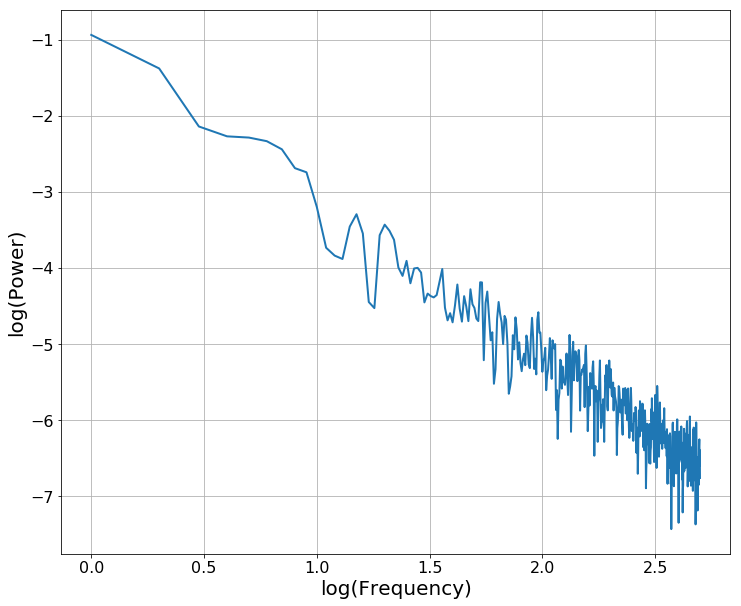

In [26]:
plot_spectrum(*compute_spectrum(sig, fs), True, True)

## Aperiodic With Periodic Component

In [55]:
sims = {
    'sim_powerlaw' : {'exponent' : -2},
    'sim_oscillation' : {'freq' : 9}}
    #'sim_oscillation' : {'freq' : 12, 'cycle' : 'sawtooth', 'width' : 0.25}}

sig = sim_combined(n_seconds, fs, sims, [1, 0.2])

In [68]:
spec_frac, spec_mixed, freq = irasa(sig, fs, subsets=15, h=np.asarray(np.linspace(1.1, 1.9, num=17)), filter=False)

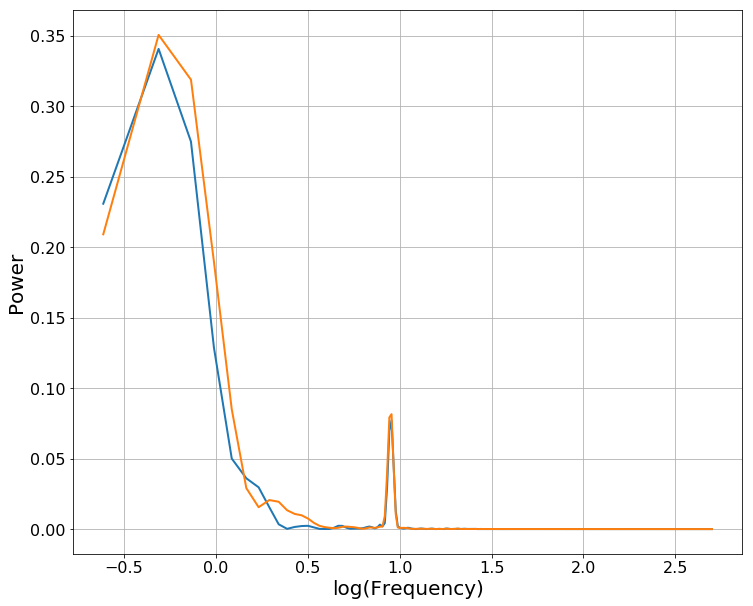

In [69]:
plot_spectra(freq, [spec_frac, spec_mixed], True, False)
#plt.xlim([0.8, 1.2])
#plot_spectra(freq, [spec_frac], True, True)

In [86]:
hset = np.arange(1.1, 5.95, 0.01)
d, e = irasa2(sig, fs, hset, None)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!


In [87]:
d = np.squeeze(d)

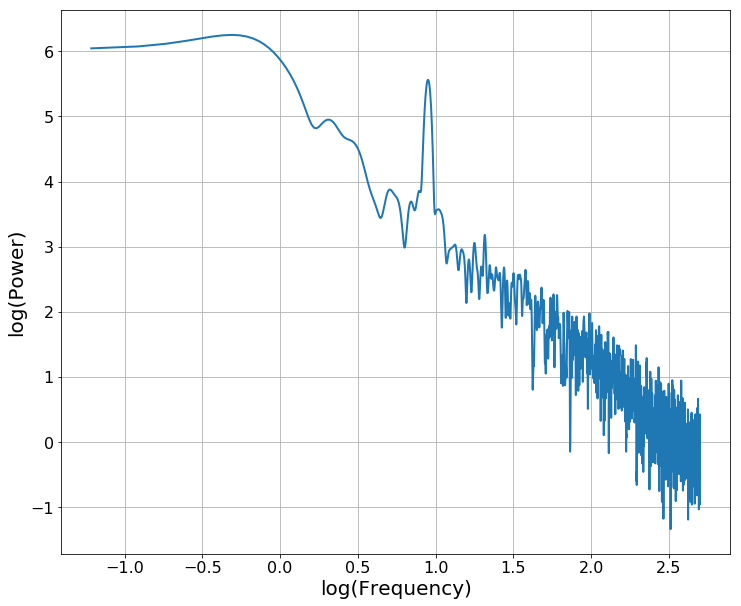

In [90]:
plot_spectrum(e, d, True, True)

In [7]:
# Copied in from dami2-sleep
#https://github.com/elanfer/dami2-sleep_classifier/blob/d4097890d239c87dc678771a9128fd4448ecb8d3/preparation/irasa.py

import math as m
import fractions
import numpy as np

import scipy.signal as sc
import scipy.interpolate as ip

import resampy

def irasa(data, s_rate, subsets=15, h=np.asarray(np.linspace(1.1, 1.9, num=17)), filter=True):
    """
    :param data: time series data  (TSD)
    :param s_rate: sampling rate of TSD in Hz
    :param subsets: number of subsets in IRASA
    :param h: upsampling parameters (should be an array with values > 1
    :param filter: flag - use anti aliasing filter
    :return:
    """
    
    # convert data to type array
    data = np.asarray(data)
    # Length of time period
    n_period = len(data)
    # the highest power of 2 that does not exceed 90 % of n_period.
    n_data = int(pow(2, np.floor(m.log(n_period * 0.9, 2))))
    # time lag between the subsets
    subset_lag = np.floor((n_period - n_data) / (subsets - 1))
    # set nfft greater than ceil(h(end)) * Ndata, asure that do fft without truncating
    nfft = pow(2, nextpow2(m.ceil(max(h)) * n_data))
    # set output data length
    n_frac = int(nfft / 2 + 1)
    freq = (s_rate / 2) * np.linspace(0, 1, n_frac)

    # compute the spectrum of mixed data
    spec_mixed = np.zeros(n_frac)
    taper = np.hanning(n_data + 1)[0:n_data]  # periodic Hanning-window for fft

    # compute the mixed periodogram for all subsets
    for k in range(subsets):
        start = int(subset_lag * k)
        end = int(start + n_data)
        sample = (data[start:end] - np.mean(data[start:end])) * taper
        powerfun = 2 * np.fft.fft(sample, n=nfft) / min(nfft, n_data)
        powerfun[0] = powerfun[0] / 2
        spec_mixed = spec_mixed + pow(abs(powerfun[0:n_frac]), 2)

    spec_mixed = spec_mixed / subsets

    # filter the input signal to avoid aliasing when downsampling
    if filter == True:
        lowcut = 0
        highcut = s_rate / (2 * m.ceil(max(h)))
        data_filtered = amri_sig_filtfft(data, fs=s_rate, lowcut=lowcut, highcut=highcut)
    else:
        data_filtered = data

    # compute fractal component.
    spec_frac = np.zeros((len(h), n_frac))

    for j in range(len(h)):
        
        # compute the auto - power spectrum of xh
        Sh = np.zeros(n_frac)
        # compute the auto - power spectrum of X1h
        S1h = np.zeros(n_frac)
        
        # compute for every single subset
        for k in range(subsets):
            start = int(subset_lag * k)
            end = int(start + n_data)
            segment_ds = data_filtered[start:end]
            segment_us = data[start:end]
            segment_ds = myresample(segment_ds, 1. / h[j])
            segment_us = myresample(segment_us, h[j])
            taper_ds = np.hanning(len(segment_ds))
            taper_us = np.hanning(len(segment_us))
            powerfun_ds = 2 * np.fft.fft((segment_ds - np.mean(segment_ds)) * taper_ds, nfft) / min(nfft,
                                                                                                    len(segment_ds))
            powerfun_us = 2 * np.fft.fft((segment_us - np.mean(segment_us)) * taper_us, nfft) / min(nfft,
                                                                                                    len(segment_us))
            powerfun_ds[0] = powerfun[0] / 2
            powerfun_us[0] = powerfun[0] / 2
            # sum up periodograms in upsampling per h
            Sh = Sh + pow(abs(powerfun[0:n_frac]), 2)
            # sum up periodograms in downs_rate per h
            S1h = S1h + pow(abs(powerfun[0:n_frac]), 2)
            
        # take the mean of periodogram in upsampling per h
        Sh = Sh / subsets
        # take the mean of periodogram in downsampling per h
        S1h = S1h / subsets
        # take the square root of the product of up- and downsampling per h
        spec_frac[j][:] = np.sqrt(Sh * S1h)

    # pick the median element out of h periodograms  per frequency
    spec_frac = np.median(spec_frac, axis=0)

    return [spec_frac, spec_mixed, freq]


# subfunctions

def myresample(data, h, interp=False):
    # resample signal with upsample = numerator and downsample = denominator of h as fraction
    if interp == True:
        N = len(data)
        # initial scale
        x0 = np.linspace(0, 1, N)
        # resampling scale
        x1 = np.linspace(0, 1, np.round_(N * h))
        # create interpolation
        res_data = ip.interp1d(x0, data)(x1)

    elif interp == "cubic":
        # fit a model to the data
        env_model = ip.interp1d(np.linspace(1, len(data), num=len(data)), data, kind='cubic', bounds_error=False,
                                fill_value=0.0)
        # estimate model points for ts
        res_data = np.asarray(env_model(np.linspace(1, len(data), num=h * len(data))))


    else:
        up = fractions.Fraction(h).numerator
        down = fractions.Fraction(h).denominator
        res_data = resampy.resample(data, down, up)

    return np.asarray(res_data)

####



def amri_sig_filtfft(ts, fs=1.0, lowcut=0.0, highcut=np.nan, trans=.15, revfilt=False, remove_trend=False):
    """
        lowpass, highpass or bandpass/stop filtering using a pair of forward and inverse fourier transform.
    :param ts: a discrete time series vector
    :param fs: sampling frequency of the time series {default = 1}
    :param lowcut: lowcutoff frequency (in Hz)
    :param highcut: highcutoff frequency (in Hz)
    :param trans: 0:band-pass; 1:band-stop {default: 0}
    :param revfilt: relative transition zone {default: 0.15}
    :return: the filtered time series vector
    """
    
    # number of time points
    npts = len(ts)
    # number of frequency points
    nfft = pow(2, nextpow2(npts))
    # even-sized frequency vector from 0 to nyguist frequency
    fv = fs / 2. * np.linspace(0., 1., int(nfft / 2 + 1))
    # frequency domain resolution
    fres = (fv[len(fv) - 1] - fv[0]) / (nfft / 2)

    # remove the linear trend
    if remove_trend == True:
        ts_old = ts
        ts = sc.detrend(ts_old, type='linear')
        trend = ts_old - ts
    else:
        trend = 0

    # desired frequency response
    filter = np.zeros(nfft) + 1

    # design frequency domain filter
    # ----------------------------------------------------------

    #
    # HIGHPASS FILTER:
    #
    #                lowcut
    #                  -----------
    #                 /
    #                /
    #               /
    #    -----------
    #         lowcut*(1-trans)

    if (~np.isnan(lowcut) and lowcut > 0) and (np.isnan(highcut) or highcut <= 0):

        idxl = int(round(lowcut / fres)) + 1
        idxlmt = int(round(lowcut * (1 - trans) / fres)) + 1
        filter[0:idxlmt] = 0
        filter[idxlmt:idxl] = 0.5 * (1 + np.sin(-m.pi / 2. + np.linspace(0, m.pi, idxl - idxlmt + 1)))
        filter_part = filter[0:idxl]
        filter[nfft - idxl - 1:nfft] = filter_part[::-1]



    #
    # LOWPASS FILTER:
    #
    #        highcut
    #       ----------
    #                 \
    #                  \
    #                   \
    #                    -----------
    #           highcut*(1+trans)

    elif (np.isnan(lowcut) or lowcut <= 0) and (~np.isnan(highcut) or highcut > 0):
        idxh = int(round(highcut / fres)) + 1
        idxhpt = int(round(highcut * (1 + trans) / fres)) + 1
        filter[idxh - 1:idxhpt] = 0.5 * (1. + np.sin(m.pi / 2. + np.linspace(0, m.pi, idxhpt - idxh + 1)))
        filter[idxhpt:int(nfft / 2)] = 0
        filter_part = filter[idxh - 1:int(nfft / 2)]
        filter[int(nfft / 2):int(nfft - idxh + 1)] = filter_part[::-1]


    elif (lowcut > 0 and highcut > 0 and highcut > lowcut):

        #
        # BANDPASS FILTER (revfilt = True)
        #
        #        lowcut                 highcut
        #                   -------
        #                  /       \    transition = (highcut - lowcut) / 2 * trans
        #                 /         \   center = (lowcut + highcut) / 2;
        #                /           \
        #         -------             -----------
        # lowcut - transition      highcut + transition

        if (revfilt == True):
            transition = (highcut - lowcut) / 2 * trans
            idxl = int(round(lowcut / fres)) + 1
            idxlmt = int(round((lowcut - transition) / fres)) + 1
            idxh = int(round(highcut / fres)) + 1
            idxhpt = int(round((highcut + transition) / fres)) + 1
            filter[0:idxlmt] = 0
            filter[idxlmt - 1:idxl] = 0.5 * (1 + np.sin(-m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
            filter[idxh - 1:idxhpt] = 0.5 * (1 + np.sin(m.pi / 2 + np.linspace(0, m.pi, idxhpt - idxh + 1)))
            filter[idxhpt - 1:int(nfft / 2)] = 0
            filter_part = filter[0:idxl]
            filter[nfft - idxl:nfft] = filter_part[::-1]
            filter_part = filter[idxh - 1:int(nfft / 2)]
            filter[int(nfft / 2):int(nfft - idxh + 1)] = filter_part[::-1]

        #
        # BANDSTOP FILTER (revfilt = False)
        #   lowcut - transition        highcut + transition
        #             -------             -----------
        #                    \           /
        #                     \         /   transition = (highcut - lowcut) / 2 * trans
        #                      \       /    center = (lowcut + highcut) / 2;
        #                       -------
        #             lowcut                 highcut

        else:
            transition = ((highcut - lowcut) / 2) * trans
            idxl = int(round(lowcut / fres)) + 1
            idxlmt = int(round((lowcut - transition) / fres)) + 1
            idxh = int(round(highcut / fres)) + 1
            idxhpt = int(round((highcut + transition) / fres)) + 1
            filter[idxlmt - 1:idxl] = 0.5 * (1 + np.sin(m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
            filter[idxh:idxhpt] = 0.5 * (1 + np.sin(-m.pi / 2 + np.linspace(0, m.pi, idxl - idxlmt + 1)))
            filter[idxl:idxh + 1] = 0
            filter_part = filter[idxlmt:idxhpt]
            filter[nfft - idxhpt:nfft - idxlmt + 1] = filter_part[::-1]

    else:
        print("amri_sig_filtfft(): error in lowcut and highcut setting")

    # fft
    X = np.fft.fft(ts, nfft)
    # ifft
    ts_new = np.real(np.fft.ifft(X * filter, nfft))
    # tranc
    ts_new = ts_new[0:npts]
    # add back the linear trend
    ts_new = ts_new + trend
    return ts_new


def nextpow2(i):
    n = m.floor(np.log2(i)) + 1
    return n

In [8]:
# IRASA Irregular-Resampling Auto-Spectral Analysis - Python version
# https://github.com/aquilesIIIMB/bioSignals/blob/3764280a52270445f0bd75f3c5672879bfa4b586/test_IRASA.ipynb
import numpy as np
from scipy.signal import hanning
from scipy.fftpack import fft, fftfreq, fftshift

def nextpow2(x):
    """returns the smallest power of two that is greater than or equal to the
    absolute value of x.
    This function is useful for optimizing FFT operations, which are
    most efficient when sequence length is an exact power of two.
    :Example:
    .. doctest::
        >>> from spectrum import nextpow2
        >>> x = [255, 256, 257]
        >>> nextpow2(x)
        array([8, 8, 9])
    """
    res = np.ceil(np.log2(x))
    return res.astype('int') #we want integer values only but ceil gives float


def irasa2(sig, srate, hset, flag_filter):
    
    # Given a discrete time series (sig) of length (Ntotal)
    if sig.ndim == 1:
        sig = np.reshape(sig,(-1,1))
        dim = 1
               
    Ntotal = sig.shape[0]

    # Ndata is the power of 2 that does not exceed 90% of Ntotal.
    Ndata = int(2 ** np.floor(np.log2(Ntotal*0.9)))

    # Nsubset is fixed to 15
    Nsubset = 15

    # compute the auto-power spectrum of the originally sampled time series
    L = np.floor((Ntotal-Ndata)/(Nsubset-1))

    # set nfft greater than ceil(hset(end))*Ndata, asure that do fft without truncating
    nfft = int(2 ** nextpow2(np.ceil(hset[len(hset)-1]) * Ndata))

    # set output data length Nfrac
    Nfrac = int(nfft / 2 );
    freq = srate / 2 * np.linspace(0,1,Nfrac)
    freq = freq[:]

    # compute the spectrum of mixed data
    Smixd = np.zeros((Nfrac,dim))
    Pmixd = [];
    
    #taper = gettaper([Ndata dim]);
    taper = hanning(Ndata)
    taper = np.tile(taper, (dim,1)).T

    for k in range(0, Nsubset):
        
        i0 = int(L * k)
        x1 = sig[i0:i0+Ndata,:]
        
        # Config Multitaper IRASA
        # pure IRASA
        p1 = fft(x1.T * taper.T, nfft) / min(nfft, x1.shape[1])
        p1 = p1.T
        Pmixd = np.array([Pmixd, np.angle(p1[0:round(Nfrac),:])])
        p1[1:,:] = p1[1:,:] * 2
        Smixd = Smixd + abs(p1[0:round(Nfrac),:]) ** 2   

    Smixd = Smixd / Nsubset
    
    return Smixd, freq

In [127]:
#
n_seconds = 10
fs = 1000
sims = {
    #'sim_powerlaw' : {'exponent' : -2},
    'sim_synaptic_current' : {},
    'sim_bursty_oscillation' : {'freq' : 25}
}

In [130]:
sig = sim_combined(n_seconds, fs, sims, [0.4, 0.6])

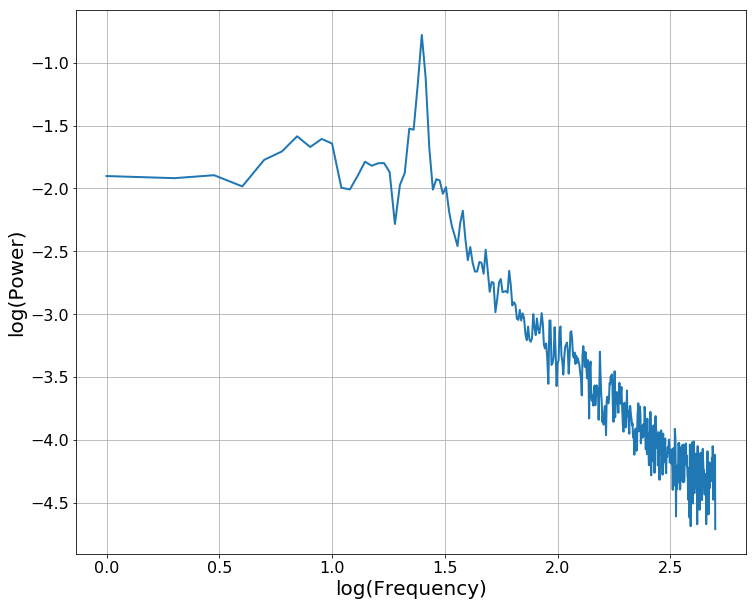

In [131]:
plot_spectrum(*compute_spectrum(sig, fs), True, True)

In [132]:
from scipy.io import savemat

In [133]:
savemat('irasa_sig.mat', {'sig':sig})